# 10 Pretraining on aux task 

In [22]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
from pathlib import Path
import requests
import pickle
import gzip
import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader


In [89]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DNN(nn.Module):
    def __init__(self,n_inputs, n_hidden, n_outputs, activation):
        super(DNN, self).__init__()
        if type(activation) == nn.ReLU():
            self.model = nn.Sequential(
            nn.Linear(n_inputs, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_outputs))
            
        elif type(activation) == nn.LeakyReLU():
            self.model = nn.Sequential(
            nn.Linear(n_inputs, n_hidden), 
            nn.LeakyReLU(), 
            nn.Linear(n_hidden, n_hidden), 
            nn.LeakyReLU(), 
            nn.Linear(n_hidden, n_hidden),
            nn.LeakyReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.LeakyReLU(),
            nn.Linear(n_hidden, n_outputs))
            
        else:
            self.model = nn.Sequential(
            nn.Linear(n_inputs, n_hidden), 
            nn.ELU(), 
            nn.Linear(n_hidden, n_hidden), 
            nn.ELU(), 
            nn.Linear(n_hidden, n_hidden),
            nn.ELU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ELU(),
            nn.Linear(n_hidden, n_outputs))
    
    def forward(self, x):
        #x = self.model(x)
        return self.model(x)

In [3]:
DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"
if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [66]:
with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

In [8]:
def sample_n_instances_per_class(X, y, n=100):
    Xs, ys = [], []
    for label in np.unique(y):
        idx = (y == label)
        Xc = X[idx][:n]
        yc = y[idx][:n]
        Xs.append(Xc)
        ys.append(yc)
    return np.concatenate(Xs), np.concatenate(ys)

In [ ]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

def init_weights(model):
    if type(model) == nn.Linear:
        nn.init.kaiming_normal_(model.weight, mode='fan_out', nonlinearity='relu')
            #print(m.weight)

In [70]:
x_train = np.concatenate((x_train,x_valid[:5000]),axis=0)
y_train = np.concatenate((y_train,y_valid[:5000]),axis=0)
x_valida = x_valid[:5000]
y_valida = y_valid[:5000]
x_train.shape

(55000, 784)

## A

In [90]:
dnn1 = DNN(784,100,1,nn.ELU())
dnn2 = DNN(784,100,1,nn.ELU())
loss_func = F.cross_entropy
opt1 = optim.Adam(dnn1.model.parameters(), lr = 0.01)
opt2 = optim.Adam(dnn2.model.parameters(), lr = 0.01)
dnn1.apply(init_weights)
dnn2.apply(init_weights)

DNN(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=100, out_features=100, bias=True)
    (7): ELU(alpha=1.0)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

## B

In [71]:
X_test = x_valid[5000:]
y_test = y_valid[5000:]
X_test.shape

(5000, 784)

In [18]:
def generate_batch(images, labels, batch_size):
    size1 = batch_size // 2
    size2 = batch_size - size1
    if size1 != size2 and np.random.rand() > 0.5:
        size1, size2 = size2, size1
    X = []
    y = []
    while len(X) < size1:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if rnd_idx1 != rnd_idx2 and labels[rnd_idx1] == labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([1])
    while len(X) < batch_size:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if labels[rnd_idx1] != labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([0])
    rnd_indices = np.random.permutation(batch_size)
    return np.array(X)[rnd_indices], np.array(y)[rnd_indices]

In [19]:
batch_size = 5
X_batch, y_batch = generate_batch(x_train, y_train, batch_size)
X_batch.shape, X_batch.dtype

((5, 2, 784), dtype('float32'))

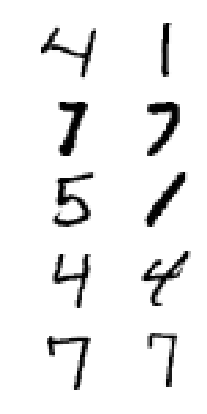

In [23]:
plt.figure(figsize=(3, 3 * batch_size))
plt.subplot(121)
plt.imshow(X_batch[:,0].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.subplot(122)
plt.imshow(X_batch[:,1].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.show()

In [24]:
y_batch

array([[0],
       [1],
       [0],
       [1],
       [1]])

## C

In [72]:
X_test1, y_test1 = generate_batch(X_test, y_test, batch_size=len(X_test))
X_test1.shape

(5000, 2, 784)

In [74]:
X_trainb, y_trainb, X_validb, y_validb = map(
    torch.tensor, (x_train, y_train, x_valida, y_valida)
)
X_testb, y_testb = map(torch.tensor,(X_test1, y_test1))
X_testb.shape

torch.Size([5000, 2, 784])

In [91]:
def fit_early_stop(epochs, model, loss_func, opt):
    bs = 500
    total = 0
    correct = 0
    best_loss = np.infty
    epochs_without_progress = 0
    running_corrects = 0.0
    max_epochs_without_progress = 20
    for epoch in range(epochs):
        model.train()
        for iteration in range(len(x_train) // bs):
            X_batch, y_batch = generate_batch(x_train, y_train, bs)
            xb, yb = map(torch.tensor,(X_batch,y_batch))
            loss_batch(model, loss_func, xb, yb, opt)
        print("loss", loss_func(model(xb),yb).item())
        model.eval()
        if epoch % 5 == 0:
            acc = accuracy(model(X_testb),y_testb)
            print ("accuracy", acc.item())

In [92]:
epochs = 100
fit_early_stop(epochs,dnn1,loss_func,opt1)

loss 0.688275158405304
accuracy 0.49540001153945923
loss 0.6966156959533691
loss 0.6919171810150146
loss 0.6971263885498047
loss 0.6919090151786804
loss 0.7012786865234375
accuracy 0.498199999332428
loss 0.694689154624939
loss 0.6951104998588562
loss 0.692688524723053
loss 0.6886424422264099
loss 0.6903759241104126
accuracy 0.501800000667572
loss 0.6884114146232605
loss 0.689602255821228
loss 0.6947542428970337
loss 0.691860020160675
loss 0.696202278137207
accuracy 0.49639999866485596
loss 0.6943578720092773
loss 0.691712498664856
loss 0.6924166679382324
loss 0.6921648979187012
loss 0.6943737864494324
accuracy 0.49480000138282776
loss 0.6937608122825623
loss 0.6947593092918396
loss 0.6897279620170593
loss 0.6939439177513123
loss 0.6938048601150513
accuracy 0.48820000886917114
loss 0.6935588121414185
loss 0.6930423378944397
loss 0.6928695440292358
loss 0.6913675665855408
loss 0.6928569674491882
accuracy 0.5013999938964844
loss 0.6928838491439819
loss 0.6928983330726624
loss 0.6924355626